<a href="https://colab.research.google.com/github/shyam97/modelling1/blob/master/Modelling_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install CoolProp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI

# Input Data

Input the initial temperature and the dimensions of the pool

In [0]:
T_now_C = 11.07
T_now = T_now_C + 273.15
A = 40
H = 1.5
V = A*H

# Control Variables

- Changing `heater = 1` will activate external heating
- Changing `convection = 1` will activate heat loss through convection
- Changing `evaporation = 1` will activate heat loss through evaporation
- Changing `solar = 1` will activate solar panel aided heating
    - Changing `control = 0` will close the solar heating feed valve
    - Changing `control = 0.5` will activate sensor which will restrict heating to user defined temperature, will take value from external heating control
    - Changing `control = 1` will open the solar heating feed valve permanently

In [0]:
heater = 1
convection = 1
evaporation = 1
solar = 1
control = 0.5

## External Heating Control

External heating to user-defined temperature

In [0]:
T_user_C = 18
T_user = T_user_C + 273.15
Q_H = 0

## Convection Control

Heat loss through convection, heat transfer coefficient taken from linear interpolation of wind data

In [0]:
Q_C = 0

def h_conv(w):
    y = 10 + (40-10)*(w-1)/(10-1)
#     return y
    return 2

## Evaporation Control

Heat and mass loss through evaporation with predefined mass loss per day

In [0]:
q_ev = PropsSI('H','P',101325,'Q',1,'Water') - PropsSI('H','P',101325,'Q',0,'Water')
V_ev = 1.1e-3/24
Q_E = 0

## Solar Panel Control

Solar panel heating with efficiency and area of panel as input

In [0]:
eff = 1
a = 10
Q_S = 0

# KNMI Weather Data

Temperature, sunshine and wind data from April 1st, 2019 to April 30th, 2019

In [0]:
array =pd.read_csv('knmi.csv', sep=',',header=None)
temp = 0.1*array.values[:,0]
shine = 1e4*array.values[:,1]
wind = 0.1*array.values[:,2]
hours = np.linspace(1,31,num=len(temp))

## Plot of local temperature

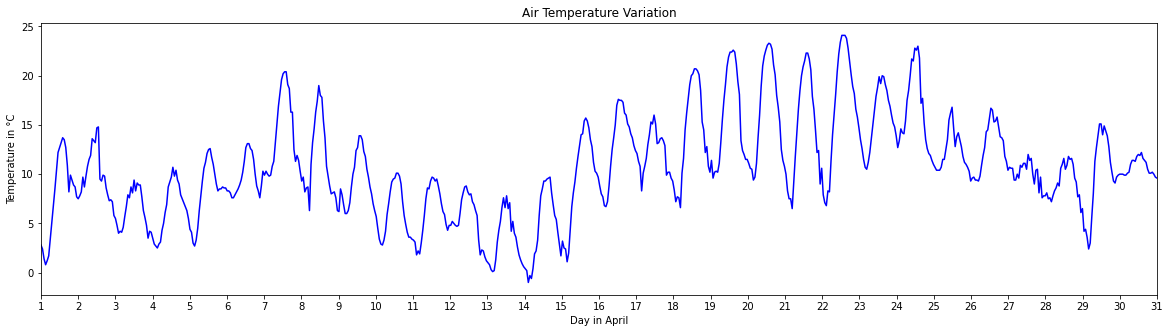

In [0]:
plt.figure(figsize=(20,5))
plt.plot(hours,temp,'b')
plt.xlim([1,30])
plt.xlabel("Day in April")
plt.ylabel("Temperature in °C")
plt.xticks(np.arange(min(hours), max(hours)+1, 1.0))
plt.title("Air Temperature Variation")
plt.show()

## Plot of Sunshine

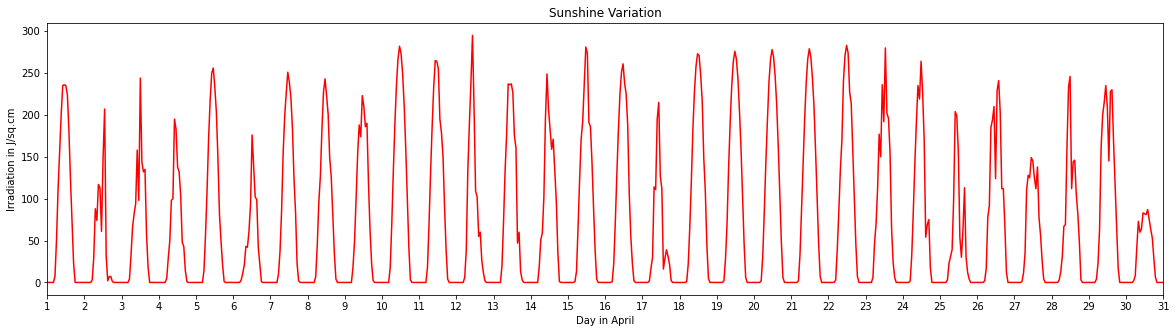

In [0]:
plt.figure(figsize=(20,5))
plt.plot(hours,1e-4*shine,'r')
plt.xlim([1,30])
plt.xlabel("Day in April")
plt.ylabel("Irradiation in J/sq.cm")
plt.xticks(np.arange(min(hours), max(hours)+1, 1.0))
plt.title("Sunshine Variation")
plt.show()

## Plot of Wind Speed

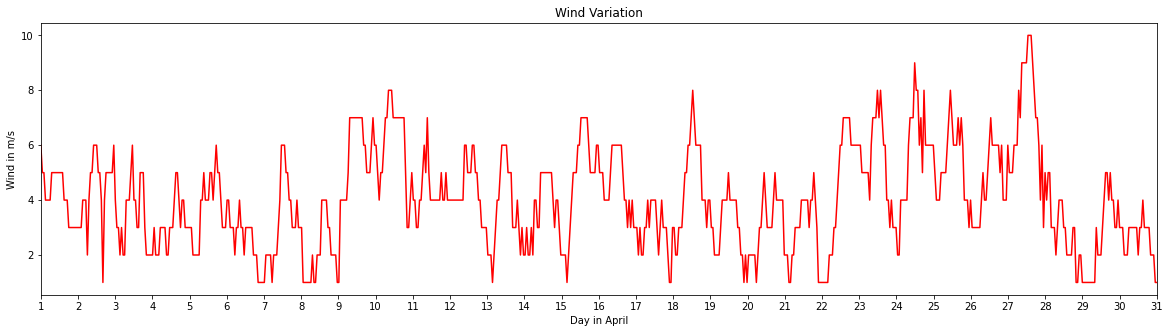

In [0]:
plt.figure(figsize=(20,5))
plt.plot(hours,wind,'r')
plt.xlim([1,30])
plt.xlabel("Day in April")
plt.ylabel("Wind in m/s")
plt.xticks(np.arange(min(hours), max(hours)+1, 1.0))
plt.title("Wind Variation")
plt.show()

# Without External Heating

In [0]:
T = np.zeros((len(temp)+1,1))
Q_CM = np.zeros((len(temp),1))
Q_EM = np.zeros((len(temp),1))
Q_SM = np.zeros((len(temp),1))
Q_M = np.zeros((len(temp),1))
T[0] = T_now

for i in range(0,len(temp)):
    if T_now < 273.15:
        print("The pool froze!")
        T = T[0:i]
        Q_M = Q_M[0:i]
        Q_CM = Q_CM[0:i]
        Q_EM = Q_EM[0:i]
        Q_SM = Q_SM[0:i]
        break
    D = PropsSI('D','P',101325,'T',T_now,'Water')  
    Cp = PropsSI('Cpmass','P',101325,'T',T_now,'Water')
    m = V*D
    
    if convection==1:
        h_c = h_conv(wind[i])
        Q_C = - h_c * A * (T_now - temp[i] - 273.15)
        Q_CM[i] = Q_C
    
    if evaporation==1:
        m1 = V*D
        m2 = m1 - D*V_ev
        m = 0.5*(m2+m1)
        Q_E = -q_ev*V_ev*D
        Q_EM[i] = Q_E
        
    if solar==1:
        if control ==1:
            Q_S = shine[i]*eff*a
        elif control==0.5:
            if T_now<T_user:
                Q_S = shine[i]*eff*a
            else:
                Q_S = 0
        else:
            Q_S = 0
        Q_SM[i] = Q_S
        
    Q = Q_S + Q_E + Q_C + Q_H*3600
    Q_M[i] = Q
    
    delT = Q/(m*Cp)
    T_next = T_now + delT
    T[i+1] = T_next
    T_now = T_next
    
    if evaporation==1:
        V = V - V_ev

## Plot of Temperature of Pool Water

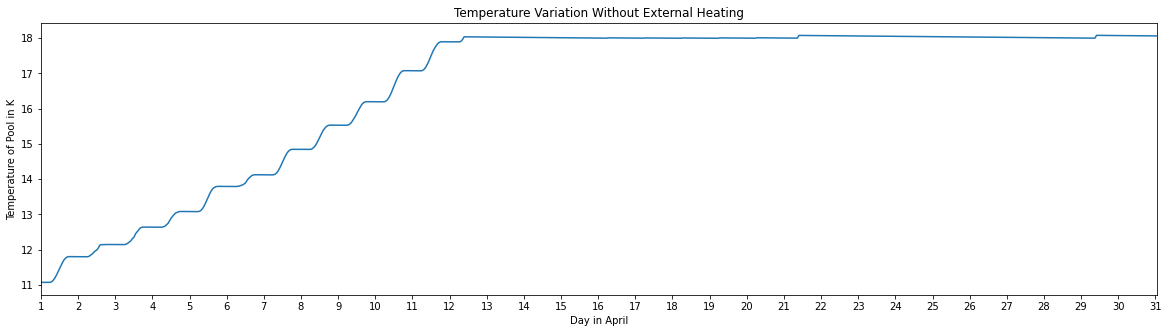

In [0]:
if convection or evaporation or solar:
    hour = np.linspace(1,len(T)/24+1,num=len(T))
    plt.figure(figsize=(20,5))
    plt.plot(hour,T-273.15)
#     plt.plot(hours,temp)
    plt.xlim([1,len(T)/24+1])
    plt.xlabel("Day in April")
    plt.ylabel("Temperature of Pool in K")
    plt.xticks(np.arange(min(hour), max(hour), 1.0))
    plt.title("Temperature Variation Without External Heating")
    plt.show()

## Plot of Heat Flux

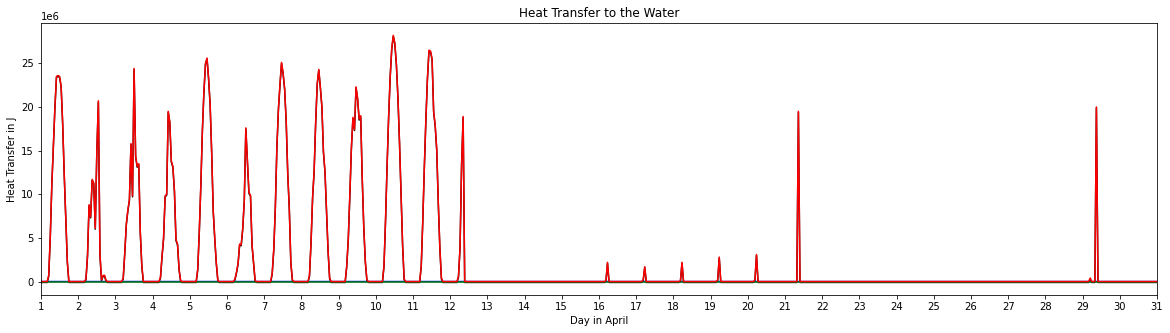

In [0]:
if convection or evaporation or solar:
    hours = np.linspace(1,len(Q_M)/24 + 1,num=len(Q_M))
    plt.figure(figsize=(20,5))
    plt.plot(hours,Q_M,'k')
    if convection==1:
        plt.plot(hours,Q_CM,'b')
    if evaporation==1:
        plt.plot(hours,Q_EM,'g')
    if solar==1:
        plt.plot(hours,Q_SM,'r')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
    plt.xticks(np.arange(min(hours), max(hours)+1, 1.0))
    plt.xlim([1,len(Q_M)/24 + 1])
    plt.xlabel("Day in April")
    plt.ylabel("Heat Transfer in J")
    plt.title("Heat Transfer to the Water")
    plt.show()
    

# With External Heating

No heater required.


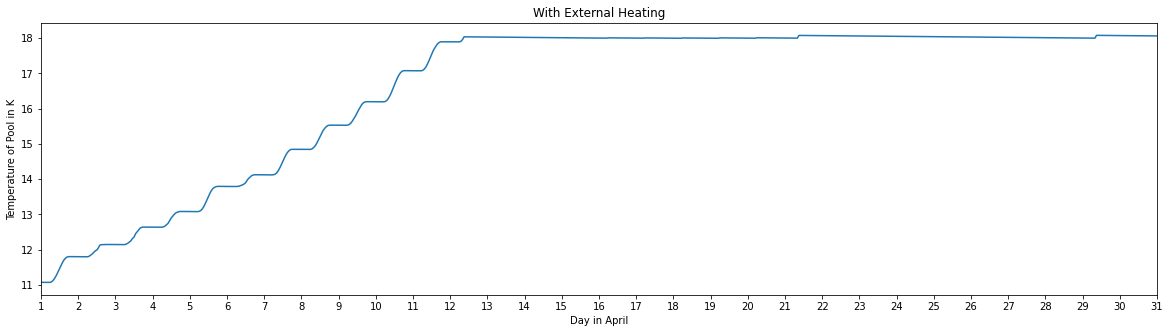

In [0]:
if heater==1:
    Q_H = 0
    if T_now > T_user:
        print("No heater required.")
    else:
        while(T_now < T_user):
            T_now = T_now_C + 273.15
            V = A*H
            T = np.zeros((len(temp)+1,1))
            T[0] = T_now
            
            for i in range(0,len(temp)):
                if T_now < 274:
                    break
                D = PropsSI('D','P',101325,'T',T_now,'Water')  
                Cp = PropsSI('Cpmass','P',101325,'T',T_now,'Water')
                m = V*D

                if convection==1:
                    h_c = h_conv(wind[i])
                    Q_C = - h_c * A * (T_now - temp[i] - 273.15)

                if evaporation==1:
                    m1 = V*D
                    m2 = m1 - D*V_ev
                    m = 0.5*(m2+m1)
                    Q_E = -q_ev*V_ev*D

                if solar==1:
                    if control ==1:
                        Q_S = shine[i]*eff*a
                    elif control==0.5:
                        if T_now<T_user:
                            Q_S = shine[i]*eff*a
                        else:
                            Q_S = 0
                    else:
                        Q_S = 0

                Q = Q_S + Q_E + Q_C + Q_H*3600

                delT = Q/(m*Cp)
                T_next = T_now + delT
                T[i+1] = T_next
                T_now = T_next
                T[i] = T_now

                if evaporation==1:
                    V = V - V_ev
                    
            Q_H = Q_H + 10
        
        units = Q_H*24*30/1000
        price = units*0.25
        print("Heater must run at %dW capacity to reach %.2f°C. Operation will cost %.2fEUR." %(Q_H,T_user-273.15,price))
        
    hour = np.linspace(1,31,num=len(T))
    plt.figure(figsize=(20,5))
    plt.plot(hour,T-273.15)
    # plt.plot(hours,temp+273.15)
    plt.xlim([1,30])
    plt.xlabel("Day in April")
    plt.ylabel("Temperature of Pool in K")
    plt.xticks(np.arange(min(hour), max(hour)+1, 1.0))
    plt.title("With External Heating")
    plt.show()